<a href="https://colab.research.google.com/github/ghazzoul12/University-project/blob/main/Project_Creditandequitybeta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Credit and equity Beta**

Presented by:


*   **Fabio Annicchiarico**
*   **Elie Ghazzoul**

*  **Francesco Paolucci**




## **Definition of a CDS**

CDSs are financial instruments, which allows transferring credit risks from a counterparty to another. They starts having effects when a risk comes out. Assuming a short position, seller agrees to pay **to premium leg**, consisting in periodic payments till the expiration, while the buyer concurs to hedge against the risk, which constitutes **the default leg**. Straightforwardly talking, CDSs are insurances against credit risk occurances.

In a Swap contract, in general we consider several ingredients.

Firstly there is the notional: it is a hypothetical amount of money on which the swap contract carries out. if it considered a notional of 1 milion euro, it means the effects underlying the contract are calculated on that notional.

Also, we consider the spread which constitutes the fixed rate; we compare the spread w.r.t. another (variable) interest rate, the one used in the market.

Let us assume an example, and assume a short position.

The seller accepts to pay periodically (to be determined in the contract, as it is negoticiated in OTC markets), this means that the interest rates will be accrued over 1-week time period till the maturity and they will regard the notional over the calculations.

On the other hand, the buyer will respond for obligations in case there credit risk comes out, that constitute the Default leg we previously considered.

#**CDS Indices**

CDS indices are used for measuring the creditworthiness of a set of corporate or government bonds in terms of negative occurrances to hold, f.i. the probability to get a default. Credit risks affects the interest rate; the more the volatility, the more the interests to pay. This means we are paid more but hold more risks.

Aiming for coping with risks and finding a way to determining it, indices can be a useful instrument for understanding how much to pay and, simultanously, getting paid for hedging counterparties' positions, from a buyer's standpoint.

The indices are mainly two: CDX concerns the American (and from developing countries) CDSs, while iTraxx concerns European ones.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Importing the Libraries**

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

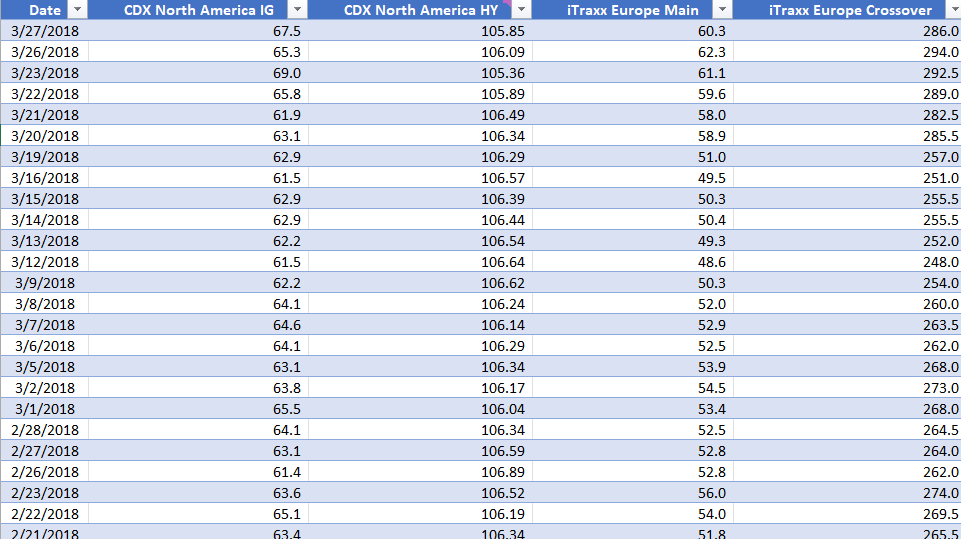

### **Dataset from Excel**

In [ ]:
file_path = '/content/drive/MyDrive/HistoricalIndices.xlsx'
df = pd.read_excel(file_path, header=0)
# Load CDS data (Sheet 1)
cds_df = pd.read_excel(file_path, sheet_name=0)
cds_df = cds_df.drop(columns=['SPY', 'IWM', 'SX5E'], errors='ignore')

# Load ETF data (Sheet 2)
etf_df = pd.read_excel(file_path, sheet_name=1)
merged_df = cds_df.merge(etf_df, on='Date', how='inner')
print(merged_df.head())

        Date  CDX North America IG  CDX North America HY  iTraxx Europe Main  \
0 2018-03-27             67.500000            105.852801              60.250   
1 2018-03-26             65.323890            106.089977              62.250   
2 2018-03-23             69.001611            105.363650              61.125   
3 2018-03-22             65.822022            105.886973              59.625   
4 2018-03-21             61.939261            106.489231              58.000   

   iTraxx Europe Crossover       SPY       IWM       SX5E  
0                    286.0  234.4168  138.1862  3316.9500  
1                    294.0  238.4737  140.9158  3278.7200  
2                    292.5  232.1230  137.9013  3298.0701  
3                    289.0  237.1784  140.9342  3348.1899  
4                    282.5  243.2592  144.0938  3401.0400  


## *Taking the last 126 avaialble data*

In [ ]:
last_126_data = merged_df.head(126)
last_126_data = last_126_data.set_index('Date').sort_index()
last_126_data.head()

,CDX North America IG,CDX North America HY,iTraxx Europe Main,iTraxx Europe Crossover,SPY,IWM,SX5E
Date,,,,,,,
2017-08-14,69.055446,106.579096,56.25,245.0,218.6763,126.2448,3450.6599
2017-08-15,69.336781,106.578649,56.50,244.5,218.6497,125.2060,3461.9099
2017-08-16,69.073731,106.578097,55.25,240.5,219.0311,125.2424,3484.5701
2017-08-17,72.252307,105.978331,57.00,245.5,215.6162,122.9551,3461.9700
2017-08-18,71.515770,106.108810,58.00,249.0,215.2791,122.9460,3446.0300


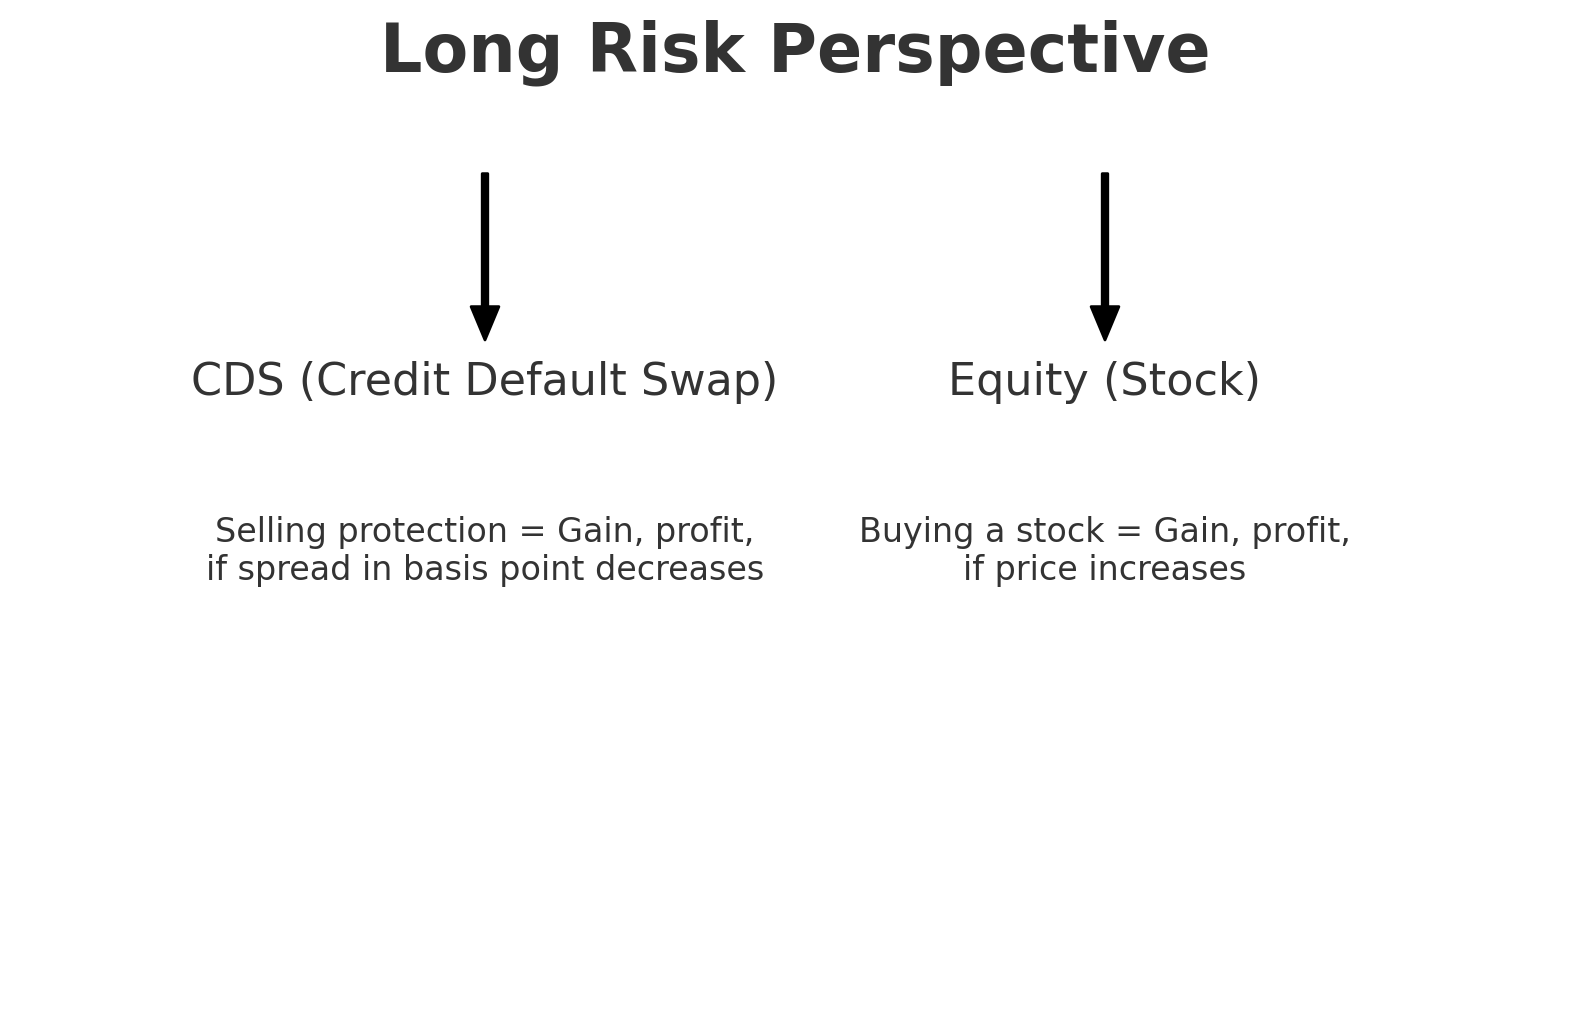

# **Risky_Dv01 and returns**
The code calculates the risky DV01 for a set of credit indices by applying a formula that adjusts the spread based on a given recovery rate, which accounts for potential losses in the event of default. The spread values, initially in basis points, are converted to decimals, and the sensitivity of each credit index to changes in spread is quantified using the risky DV01 formula. Afterward, the .diff() method is used to compute the changes in spread values, reflecting shifts in market conditions over time. The return for each index is then calculated by multiplying the DV01 by these spread changes, offering insight into how each index's price reacts to small variations in credit spreads. Additionally, market returns, such as those for SPY and SX5E, are computed to compare the credit index returns against broader market movements, providing a benchmark for evaluating credit risk in relation to the overall market performance. This approach models the price sensitivity of credit indices to minor spread changes and evaluates their performance against general market trends.


The formula for **DV01** (Dollar Value of 1 Basis Point) is:

$$
\text{DV01} = \frac{1 - \exp\left( -(r + h) \cdot T \right)}{r + h}
$$

Where:
- \( r \) is the **interest rate**.
- \( h \) is the **adjusted spread**, accounting for the **recovery rate** (i.e., the portion of the asset's value expected to be recovered in case of default).

And where h can be derived from the credit triangle formula:
$$
\text{h}=\frac{s}{1-R}
$$
- \( T \) is the **maturity period**.

This formula calculates the sensitivity of the asset price to small changes in the spread, factoring in both interest rates and the asset’s recovery assumptions.



In [ ]:
def risky_DV01(spread, interest_rate, maturity, recovery):
    spread = spread / 10000  # Convert basis points to decimal
    h = spread / (1 - recovery)
    return (1 - np.exp(-(interest_rate + h) * maturity)) / (interest_rate + h)


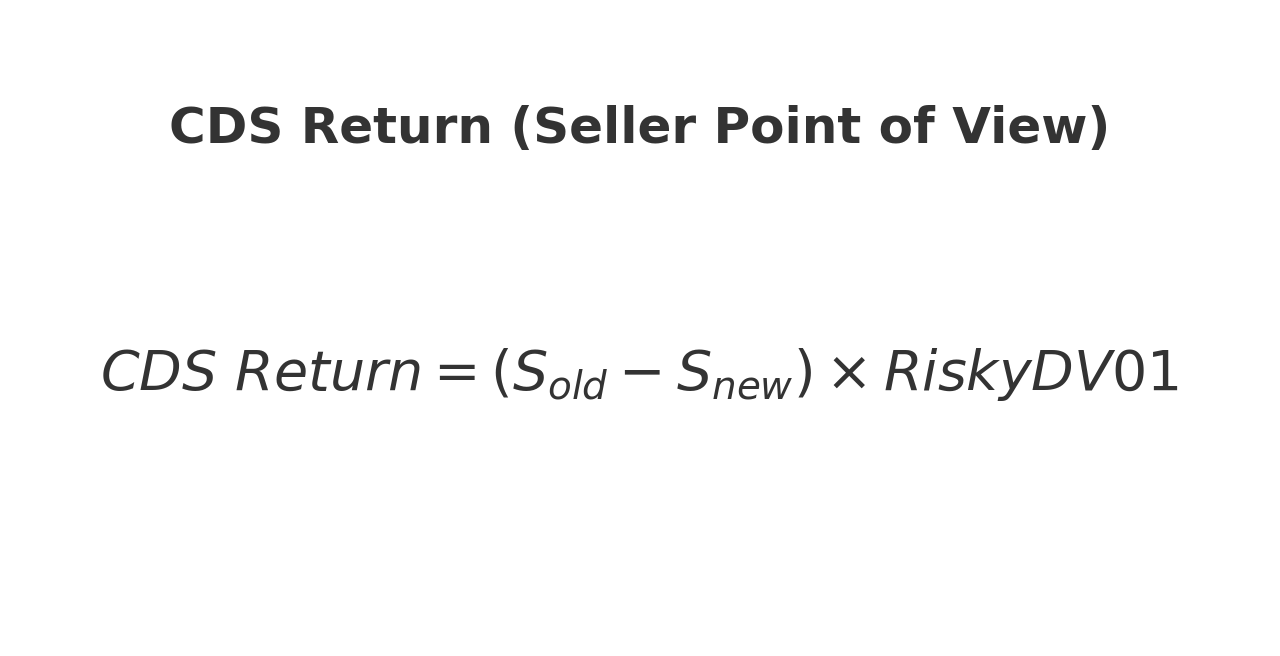

In [ ]:
columns_to_calculate = ['CDX North America IG', 'iTraxx Europe Main','iTraxx Europe Crossover']

# Apply risky_DV01 computation to each column
for col in columns_to_calculate:
  if col == 'iTraxx Europe Main':
    last_126_data[f'{col}_DV01'] = last_126_data[col].apply(
        lambda spread: risky_DV01(spread, interest_rate=0.02, maturity=5, recovery=0.2))
  else :
    last_126_data[f'{col}_DV01'] = last_126_data[col].apply(
        lambda spread: risky_DV01(spread, interest_rate=0.02, maturity=5, recovery=0.4))
for col in columns_to_calculate:
    last_126_data[f'{col}_diff'] = last_126_data[col].diff()

# Calculate the product of the diff and DV01 for each relevant column
last_126_data['iTraxx Europe Main_Return'] = -last_126_data['iTraxx Europe Main_DV01'] * last_126_data['iTraxx Europe Main_diff'] /10000
last_126_data['iTraxx Europe Crossover_Return'] = -last_126_data['iTraxx Europe Crossover_DV01'] * last_126_data['iTraxx Europe Crossover_diff'] /10000
last_126_data['CDX North America IG_Return'] = -last_126_data['CDX North America IG_DV01'] * last_126_data['CDX North America IG_diff']/10000


print(last_126_data.head())


            CDX North America IG  CDX North America HY  iTraxx Europe Main  \
Date                                                                         
2017-08-14             69.055446            106.579096               56.25   
2017-08-15             69.336781            106.578649               56.50   
2017-08-16             69.073731            106.578097               55.25   
2017-08-17             72.252307            105.978331               57.00   
2017-08-18             71.515770            106.108810               58.00   

            iTraxx Europe Crossover       SPY       IWM       SX5E  \
Date                                                                 
2017-08-14                    245.0  218.6763  126.2448  3450.6599   
2017-08-15                    244.5  218.6497  125.2060  3461.9099   
2017-08-16                    240.5  219.0311  125.2424  3484.5701   
2017-08-17                    245.5  215.6162  122.9551  3461.9700   
2017-08-18                    249

## *Since the data of CDX HY is in prices, we directly compute the simple returns.*

Calculating simple returns is done using:
\begin{equation}
R=\frac{P_i - P_j}{P_j}
\end{equation}

In [ ]:
last_126_data['SPY_Return'] = last_126_data['SPY'].diff()/last_126_data['SPY'].shift()
last_126_data['SX5E_Return'] = last_126_data['SX5E'].diff()/last_126_data['SX5E'].shift()
last_126_data['CDX North America HY_Return'] = last_126_data['CDX North America HY'].diff()/last_126_data['CDX North America HY'].shift()

In [ ]:
#In order to clear any NA from our dataset
last_126_data = last_126_data.dropna()
last_126_data.head()

,CDX North America IG,CDX North America HY,iTraxx Europe Main,iTraxx Europe Crossover,SPY,IWM,SX5E,CDX North America IG_DV01,iTraxx Europe Main_DV01,iTraxx Europe Crossover_DV01,CDX North America IG_diff,iTraxx Europe Main_diff,iTraxx Europe Crossover_diff,iTraxx Europe Main_Return,iTraxx Europe Crossover_Return,CDX North America IG_Return,SPY_Return,SX5E_Return,CDX North America HY_Return
Date,,,,,,,,,,,,,,,,,,,
2017-08-15,69.336781,106.578649,56.50,244.5,218.6497,125.2060,3461.9099,4.625501,4.676474,4.312011,0.281336,0.25,-0.5,-0.000117,0.000216,-1.301318e-04,-0.000122,0.003260,-0.000004
2017-08-16,69.073731,106.578097,55.25,240.5,219.0311,125.2424,3484.5701,4.625995,4.678260,4.318841,-0.263050,-1.25,-4.0,0.000585,0.001728,1.216869e-04,0.001744,0.006546,-0.000005
2017-08-17,72.252307,105.978331,57.00,245.5,215.6162,122.9551,3461.9700,4.620034,4.675760,4.310305,3.178576,1.75,5.0,-0.000818,-0.002155,-1.468513e-03,-0.015591,-0.006486,-0.005627
2017-08-18,71.515770,106.108810,58.00,249.0,215.2791,122.9460,3446.0300,4.621414,4.674332,4.304344,-0.736537,1.00,3.5,-0.000467,-0.001507,3.403843e-04,-0.001563,-0.004604,0.001231
2017-08-21,71.513799,106.129791,58.20,250.5,215.4477,122.8640,3423.5300,4.621418,4.674047,4.301792,-0.001971,0.20,1.5,-0.000093,-0.000645,9.107705e-07,0.000783,-0.006529,0.000198


# **Beta Calculation**
This part of the code calculates beta coefficients to measure the sensitivity and relationship between the returns of credit indices (CDX IG, CDX HY) and an equity index (SPY). The process involves three key steps:
1.Compute the covariance between two return series to capture their co-movement.
2.Calculate the variance of the independent variable to assess its total variability.
3.Use these to calculate beta as the ratio of covariance to variance, which quantifies relative sensitivity.
### The Main Formula for Beta



$$
\beta = \frac{\mathrm{Cov}(X, Y)}{\mathrm{Var}(X)}
$$

- **Cov(X, Y)**: Measures how returns of asset \(X\) (e.g., CDX IG) co-vary with asset \(Y\) (e.g., SPY).  
- **Var(X)**: Represents the variability of the independent variable \(X\).  

#### Beta Interpretation:
- A (β > 1) suggests that \(Y\) is highly sensitive to \(X\).  
- A (Β < 1) implies weaker sensitivity.





- **Cov(X, Y)**: Measures how returns of asset \(X\) (e.g., CDX IG) co-vary with asset \(Y\) (e.g., SPY).  
- **Var(X)**: Represents the variability of the independent variable \(X\).  


In [ ]:
# Calculate the covariance between SPY_Return and Cdx North America IG_Return
cov_CDXIG_SPY = last_126_data['CDX North America IG_Return'].cov(last_126_data['SPY_Return'])
var_CDXig = last_126_data['CDX North America IG_Return'].var()
beta_CDXIG_SPY = cov_CDXIG_SPY / var_CDXig

cov_CDXHY_SPY = last_126_data['CDX North America HY_Return'].cov(last_126_data['SPY_Return'])
var_CDXHY = last_126_data['CDX North America HY_Return'].var()
beta_CDXhY_SPY = cov_CDXHY_SPY / var_CDXHY

cov_CDX_HYIG= last_126_data['CDX North America IG_Return'].cov(last_126_data['CDX North America HY_Return'])
beta_CDX_HYIG=cov_CDX_HYIG/var_CDXig
beta_CDX_IGHY=cov_CDX_HYIG/var_CDXHY
# Print the result
print(f"Beta of Cdx North America IG_Return relative to SPY_Return: {beta_CDXIG_SPY}")
print(f"Beta of Cdx North America HY_Return relative to SPY_Return: {beta_CDXhY_SPY}")
print(f"Beta of Cdx North America IG_Return relative to Cdx North America HY_Return: {beta_CDX_HYIG}")

Beta of Cdx North America IG_Return relative to SPY_Return: 7.860054685281204
Beta of Cdx North America HY_Return relative to SPY_Return: 1.9718317647830355
Beta of Cdx North America IG_Return relative to Cdx North America HY_Return: 3.3255619545212824


#Beta interpretation
### 1. Beta of CDX North America IG_Return relative to SPY_Return: 7.860

 $$β=\frac{Cov(CDX.IG,SPY)}{Var(CDX . IG)}$$
**Interpretation:**

A beta of 7.86 indicates that for every 1% change in the return of CDX North America IG, the return of SPY changes by 7.86% in the same direction.
This high beta suggests that the S&P 500 (SPY) is highly sensitive to changes in investment-grade credit risk.
Widening IG credit spreads (indicating increased credit risk) are typically linked to economic stress, which significantly impacts equity markets.

###2. Beta of CDX North America HY_Return relative to SPY_Return: 1.972

 $$β=\frac{Cov(CDX.HY,SPY)}{Var(CDX . HY)}$$
**Interpretation**:

A beta of 1.97 indicates that for every 1% change in the return of CDX North America HY, the return of SPY changes by 1.97% in the same direction.
HY indices focus on lower-rated, riskier bonds, which are driven more by issuer-specific credit events rather than systemic factors.



###3. Beta of CDX North America IG_Return relative to CDX North America HY_Return: 3.32556
$$β=\frac{Cov(CDX.IG,CDX.HY)}{Var(CDX . IG)}$$
**Interpretation:**

A beta of 3.33 indicates that for every 1% change in the return of CDX IG, the return of CDX HY changes by 3.33% in the same direction.
This high beta reflects the fact that HY credit spreads are more volatile to IG, while IG spreads are more stable (lower variance).

**Key Insight:**

High-yield bonds are issued by entities with lower credit ratings, making them more susceptible to credit events. In contrast, the CDX IG index comprises bonds from issuers with higher credit ratings, indicating lower default risk and, consequently, less volatility

In [ ]:
# Compute beta for iTraxx Europe Main_Return relative to SX5E_Return
cov_main_sx5e = last_126_data['iTraxx Europe Main_Return'].cov(last_126_data['SX5E_Return'])
var_itraxxM = last_126_data['iTraxx Europe Main_Return'].var()
beta_main_sx5e = cov_main_sx5e / var_itraxxM
print(f"Beta of iTraxx Europe Main_Return relative to SX5E_Return: {beta_main_sx5e}")

# Compute beta for iTraxx Europe Crossover_Return relative to SX5E_Return
cov_crossover_sx5e = last_126_data['iTraxx Europe Crossover_Return'].cov(last_126_data['SX5E_Return'])
var_itraxxC = last_126_data['iTraxx Europe Crossover_Return'].var()
beta_crossover_sx5e = cov_crossover_sx5e / var_itraxxC
print(f"Beta of iTraxx Europe Crossover_Return relative to SX5E_Return: {beta_crossover_sx5e}")

cov_crossover_main = last_126_data['iTraxx Europe Crossover_Return'].cov(last_126_data['iTraxx Europe Main_Return'])
beta_crossover_main = cov_crossover_main / var_itraxxM
print(f"Beta of iTraxx Europe Crossover_Return relative to itraxx europe main_return: {beta_crossover_main}")


Beta of iTraxx Europe Main_Return relative to SX5E_Return: 3.3097932517432036
Beta of iTraxx Europe Crossover_Return relative to SX5E_Return: 0.5343067697427185
Beta of iTraxx Europe Crossover_Return relative to itraxx europe main_return: 3.164857707447962


#Beta Interpretation
###4. Beta of iTraxx Europe Main_Return relative to SX5E_Return: 3.309793

 $$β=\frac{Cov(iTraxx Main,SX5E)}{Var(iTraxx Main)}$$
**Interpretation:**

A beta of 3.31 indicates that for every 1% change in the return of iTraxx Europe Main, the return of SX5E (Euro Stoxx 50) changes by 3.31% in the same direction.
This shows that European equities are highly sensitive to changes in the iTraxx Main, which reflects systemic credit risk in high-grade European corporates.
Similar to CDX IG, iTraxx Main is deeply tied to macroeconomic conditions.



###5. Beta of iTraxx Europe Crossover_Return relative to SX5E_Return: 0.5343

 $$β=\frac{Cov(iTraxx Crossover,SX5E)}{Var(iTraxx crossover)}$$

**Interpretation:**

A beta of 0.53 indicates that for every 1% change in the return of iTraxx Europe Crossover, the return of SX5E changes by only 0.53% in the same direction.



###6. Beta of iTraxx Europe Crossover_Return relative to iTraxx Europe Main_Return: 3.1648577
 $$β=\frac{Cov(iTraxx Crossover,iTraxx Main)}{Var(iTraxx cMain)}$$

**Interpretation:**

A beta of 3.16 indicates that for every 1% change in the return of iTraxx Main, the return of iTraxx Crossover changes by 3.16% in the same direction.
This high beta reflects the fact that while Crossover is more independent from equities, it amplifies the movements of Main due to its higher risk profile.
When systemic risks increase, sub-investment-grade credit (Crossover) reacts more dramatically than investment-grade credit (Main).

**Key Insight:**

Crossover behaves typically as a CDX HY which is more volatile than the Main that is compared to CDX IG.

## *Plotting our results*

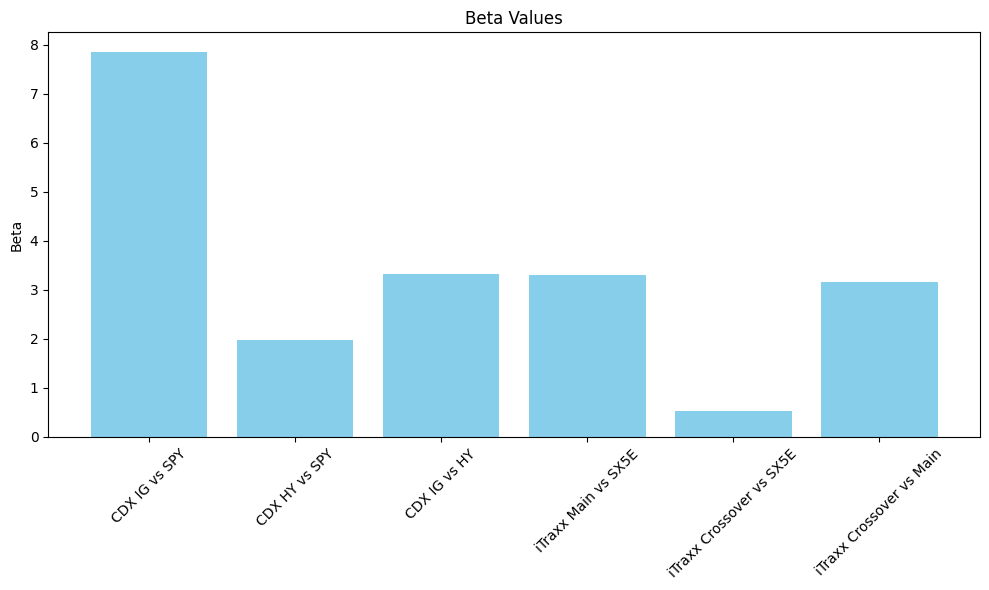

In [ ]:
beta_values = {
    'CDX IG vs SPY': beta_CDXIG_SPY,
    'CDX HY vs SPY': beta_CDXhY_SPY,
    'CDX IG vs HY': beta_CDX_HYIG,
    'iTraxx Main vs SX5E': beta_main_sx5e,
    'iTraxx Crossover vs SX5E': beta_crossover_sx5e,
    'iTraxx Crossover vs Main': beta_crossover_main
}

plt.figure(figsize=(10, 6))
plt.bar(beta_values.keys(), beta_values.values(), color='skyblue')
plt.title('Beta Values')
plt.ylabel('Beta')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



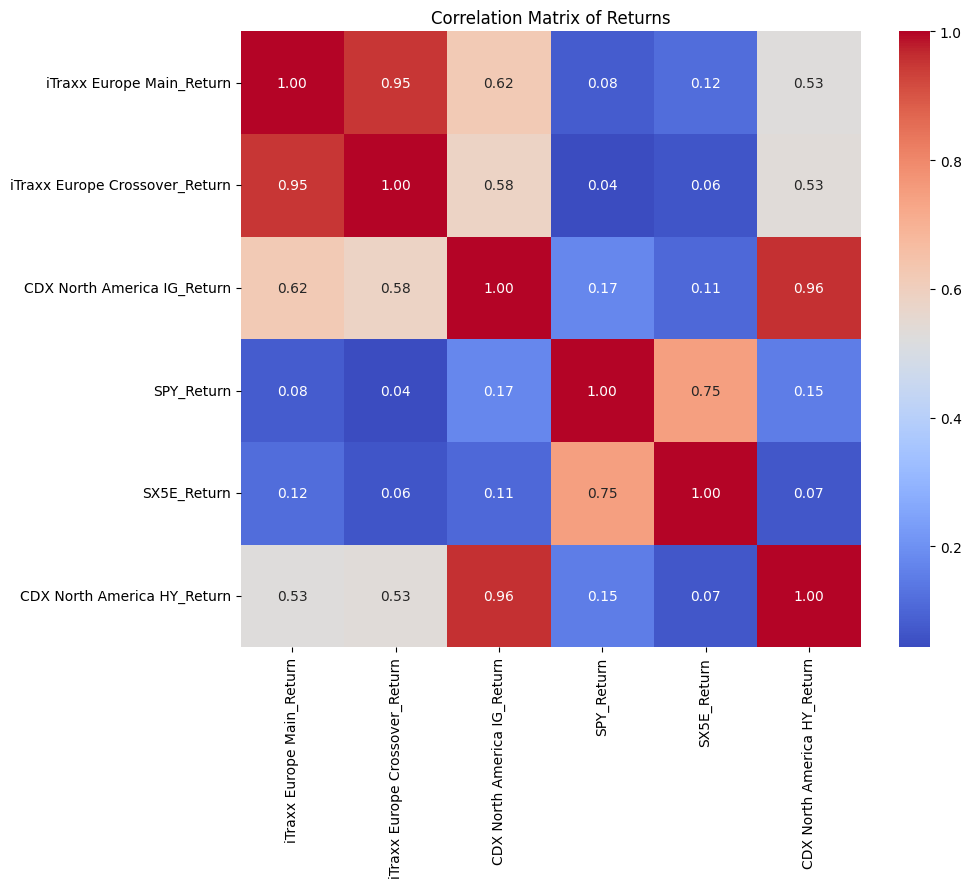

In [ ]:
# 2. Correlation Heatmap
plt.figure(figsize=(10, 8))
selected_columns = [
    'iTraxx Europe Main_Return',
    'iTraxx Europe Crossover_Return',
    'CDX North America IG_Return',
    'SPY_Return',
    'SX5E_Return',
    'CDX North America HY_Return'
]

# Compute the correlation matrix for the selected columns
correlation_matrix = last_126_data[selected_columns].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix of Returns')
plt.show()